<a href="https://colab.research.google.com/github/nguyenduongtri5703/sugarcane_leaf_disease_classification/blob/main/Sugarcan_Leaf_Disease_With_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bước 1: Import thư viện cần thiết và kết nối Drive

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files

# Cài đặt thư viện split-folders
!pip install split-folders
import splitfolders

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/model_history'

Mounted at /content/gdrive
/content/gdrive/MyDrive/model_history


Bước 2: Chuẩn bị dữ liệu

In [ ]:
# Tạo thư mục tạm thời
!mkdir /content/sugarcane_leaf_dataset

# Giải nén vào thư mục tạm thời
!unzip /content/gdrive/MyDrive/dataset/SugarcaneLeafDataset.zip -d /content/sugarcane_leaf_dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image564.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image565.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image566.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image567.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image568.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image569.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image570.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image571.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image572.jpg  
  inflating: /content/sugarcane_leaf_dataset/SugarcaneLeafDataset/Brown Spot/image573.jpg  
  inflating: /content/s

In [ ]:
# Đường dẫn đến thư mục chứa hình ảnh
input_folder = '/content/sugarcane_leaf_dataset/SugarcaneLeafDataset'
output_folder = '/content/sugarcane'  # Thư mục đầu ra

# Chia dữ liệu theo tỷ lệ 80% cho train, 10% cho validation, 10% cho test
splitfolders.ratio(input_folder, output=output_folder, ratio=(.8, .1, .1), seed=42)

Copying files: 6748 files [00:03, 1790.24 files/s]


In [ ]:
# Cấu hình ImageDataGenerator với các kỹ thuật tăng cường
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    rotation_range=30,               # Xoay ảnh ngẫu nhiên trong khoảng 0 - 30 độ
    width_shift_range=0.2,           # Dịch chuyển ngang ngẫu nhiên 20%
    height_shift_range=0.2,          # Dịch chuyển dọc ngẫu nhiên 20%
    shear_range=0.2,                 # Phép biến dạng (shear) ảnh ngẫu nhiên
    zoom_range=0.2,                  # Phóng to/thu nhỏ ảnh ngẫu nhiên
    horizontal_flip=True,            # Lật ngang ngẫu nhiên
    fill_mode='nearest'              # Điền giá trị vào các vùng trống khi xoay hoặc dịch chuyển
)
train_loader = train_datagen.flow_from_directory(
    directory = "/content/sugarcane/train",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_loader = val_datagen.flow_from_directory(
    directory="/content/sugarcane/val",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_loader = test_datagen.flow_from_directory(
    directory="/content/sugarcane/test",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 5393 images belonging to 11 classes.
Found 671 images belonging to 11 classes.
Found 684 images belonging to 11 classes.


Bước 3: Xây dựng mô hình CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(11, activation='softmax')  # 11 lớp đầu ra cho 11 loại bệnh
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Bước 4: Huấn luyện mô hình và lưu lại mô hình sau mỗi epoch

In [ ]:
# Đường dẫn đầy đủ để lưu checkpoint
checkpoint_path = '/content/gdrive/MyDrive/model_history/cnn_model_checkpoint.keras'  # Đổi thành .keras

# Cấu hình ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',            # Hoặc 'val_accuracy' tùy theo tiêu chí bạn muốn theo dõi
    save_best_only=False,          # Lưu lại model mỗi epoch
    save_weights_only=False,       # Lưu toàn bộ mô hình
    verbose=1                      # In ra thông báo khi lưu checkpoint
)

In [ ]:
# Train lần đầu với 20 epoch
model_training_history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=20,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4110 - loss: 2.2530
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1464s 9s/step - accuracy: 0.4113 - loss: 2.2505 - val_accuracy: 0.2563 - val_loss: 4.7952
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5532 - loss: 1.3569
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1461s 9s/step - accuracy: 0.5532 - loss: 1.3567 - val_accuracy: 0.2593 - val_loss: 3.7772
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5963 - loss: 1.1785
Epoch 3: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1453s 9s/step - accuracy: 0.5964 - loss: 1.1783 - val_accuracy: 0.5067 - val_loss: 1.7277
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6351 - loss: 1.0622
Epoch 4: saving model to /content

In [ ]:
# Đường dẫn đầy đủ để lưu checkpoint
checkpoint_path = '/content/gdrive/MyDrive/model_history/cnn_model_checkpoint_v2.keras'  # Đổi thành .keras

# Cấu hình ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',            # Hoặc 'val_accuracy' tùy theo tiêu chí bạn muốn theo dõi
    save_best_only=False,          # Lưu lại model mỗi epoch
    save_weights_only=False,       # Lưu toàn bộ mô hình
    verbose=1                      # In ra thông báo khi lưu checkpoint
)

In [ ]:
model_training_history = load_model('/content/gdrive/MyDrive/model_history/cnn_model_checkpoint.keras')
model_training_history.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,440,867 (112.31 MB)

 Trainable params: 9,813,387 (37.44 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 19,626,776 (74.87 MB)

In [ ]:
history = model_training_history.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8358 - loss: 0.4499
Epoch 1: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1280s 8s/step - accuracy: 0.8358 - loss: 0.4499 - val_accuracy: 0.6080 - val_loss: 1.7047
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8414 - loss: 0.4433
Epoch 2: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1277s 7s/step - accuracy: 0.8414 - loss: 0.4434 - val_accuracy: 0.9001 - val_loss: 0.3020
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8447 - loss: 0.4097
Epoch 3: saving model to /content/gdrive/MyDrive/model_history/cnn_model_checkpoint_v2.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1281s 7s/step - accuracy: 0.8447 - loss: 0.4098 - val_accuracy: 0.8450 - val_loss: 0.5478
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8344 - loss: 0.4429
Epoch 4: saving model to /content/g

Bước 5: Đánh giá mô hình dựa trên classification_report
python

In [ ]:
# Dự đoán trên tập test
Y_pred = model_training_history.predict(test_loader)
y_pred = np.argmax(Y_pred, axis=1)

# In classification report
print('Classification Report')
target_names = list(test_loader.class_indices.keys())
print(classification_report(test_loader.classes, y_pred, target_names=target_names))

22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Classification Report
                  precision    recall  f1-score   support

Banded Chlorosis       0.86      0.92      0.89        48
      Brown Spot       0.95      0.94      0.94       173
       BrownRust       0.71      0.91      0.79        32
    Dried Leaves       1.00      0.80      0.89        35
    Grassy shoot       0.95      1.00      0.97        36
  Healthy Leaves       0.93      0.93      0.93        43
    Pokkah Boeng       0.68      0.84      0.75        31
        Sett Rot       1.00      1.00      1.00        66
   Viral Disease       0.92      0.84      0.88        67
     Yellow Leaf       0.92      0.93      0.92       120
            smut       0.76      0.58      0.66        33

        accuracy                           0.90       684
       macro avg       0.88      0.88      0.88       684
    weighted avg       0.91      0.90      0.90       684



Bước 6: Vẽ ROC curve và in confusion matrix

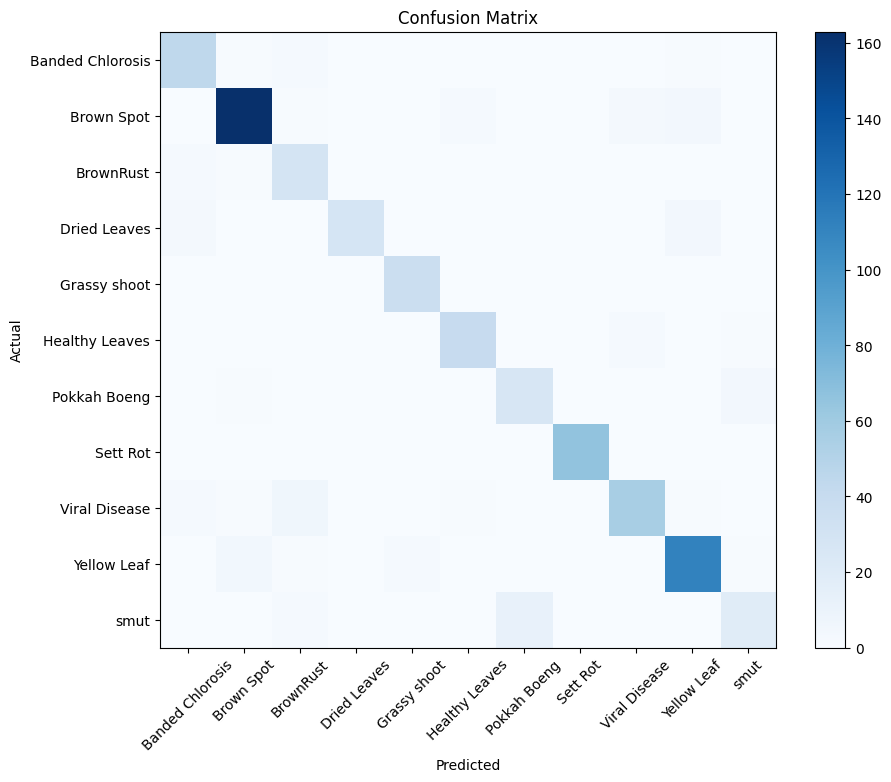

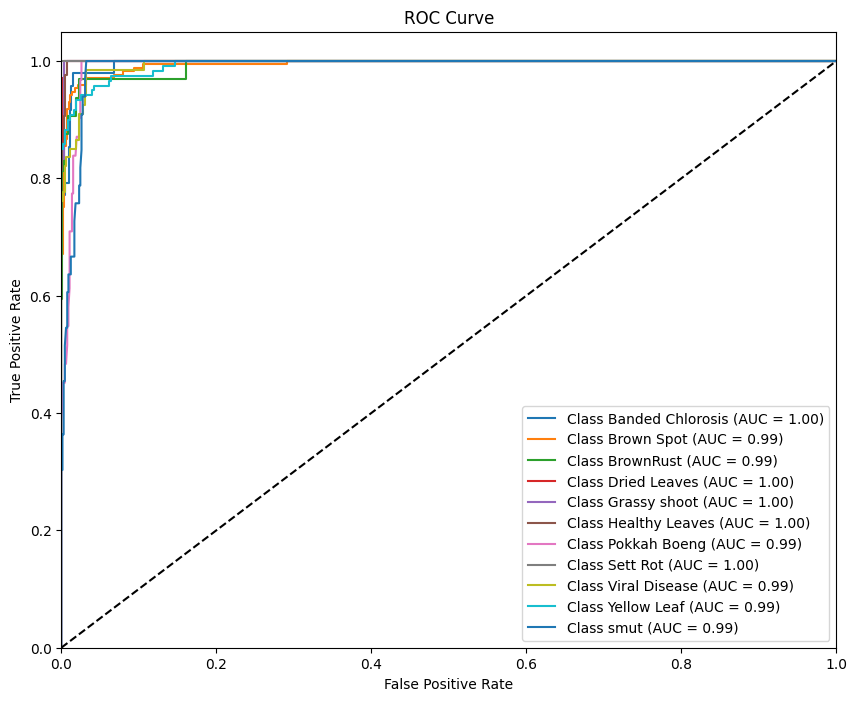

In [ ]:
# In confusion matrix
cm = confusion_matrix(test_loader.classes, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Vẽ ROC curve cho từng lớp
fpr = {}
tpr = {}
roc_auc = {}
for i in range(11):
    fpr[i], tpr[i], _ = roc_curve(test_loader.classes == i, Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ biểu đồ ROC
plt.figure(figsize=(10, 8))
for i in range(11):
    plt.plot(fpr[i], tpr[i], label=f'Class {target_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Bước 7: Xuất kết quả huấn luyện và lưu về máy

In [ ]:
# Lưu lịch sử huấn luyện thành file csv
history_df = pd.DataFrame(model_training_history.history)
history_df.to_csv('cnn_training_history.csv', index=False)

# Tải file về máy
files.download('cnn_training_history.csv')

ValueError: DataFrame constructor not properly called!